In [66]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np

In [72]:
BASE_DIR = 'data'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')
test_dir = os.path.join(BASE_DIR, 'test')

classes = os.listdir(train_dir)
n_classes = len(classes)
print(classes)

['clock', 'telephone', 'chair']


## Prepare data

In [4]:
IMAGE_SIZE = (128,128)
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000

In [55]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      shuffle=True,
                                                      label_mode='categorical',
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMAGE_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                      label_mode='categorical',
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMAGE_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      label_mode='categorical',
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMAGE_SIZE)

Found 2880 files belonging to 3 classes.
Found 960 files belonging to 3 classes.
Found 960 files belonging to 3 classes.


(64, 128, 128, 3) (64, 3)


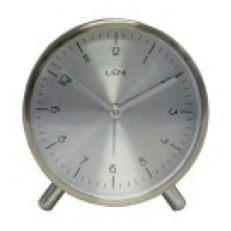

In [47]:
for batch, lbl in train_ds.take(1):
    print(batch.shape, lbl.shape)
    plt.axis('off')
    plt.imshow(batch[0]/255.0)

In [44]:
CROP_SIZE = 128
RESIZE_TO = (135, 135)

In [53]:
train_ds = train_ds.repeat(2).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

## Create model

In [70]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation((-.02, .02),
                                      (-.02, .02),
                                      fill_mode='constant'),
    tf.keras.layers.RandomCrop(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    tf.keras.layers.RandomContrast(.3) 
])

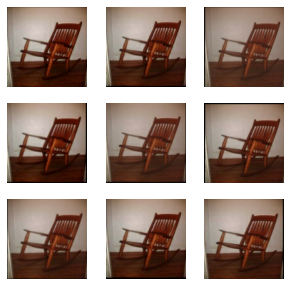

In [71]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(5, 5))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [75]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url)

HTTPError: HTTP Error 403: Forbidden

In [76]:
class BitClassifier(tf.keras.Model):
    def __init__(self, n_classes, module, augment, **kwargs):
        super(BitClassifier, self).__init__(**kwargs)
        
        self.augment = augment
        self.module = module
        self.head = tf.keras.layers.Dense(n_classes)
        
    def call(self, X):
        X = self.augment(X)
        X = self.module(X)
        return self.head(X)
    
model = BitClassifier(n_classes, module, data_augmentation)

NameError: name 'module' is not defined

In [74]:
initial_lr = 1e-3
boundaries = [200, 300]
values = [initial_lr, initial_lr*.1, initial_lr*.01]
lr_schedular = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=boundaries,
                                                                   values=values)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedular)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

SyntaxError: invalid syntax (2727688306.py, line 3)

In [ ]:
model.compile(optimzer=optimizer,
             loss=loss_fn,
             metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                   validation_data=val_ds,
                   step_per_epoch=30
                   epochs=100)

## Save model

In [ ]:
from time import strftime

os.makedirs(os.path.join("saved-model"), exist_ok==True)
export_dir = os.path.join("saved-model", strftime("%H:%M:%S"))
tf.saved_model.save(model, export_dir)